In [32]:
import sherpa
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/writeup')
from config import C_COMMON, C_GRID, C_SINGLE, FILENAME

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# enable autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df = pd.read_csv(FILENAME, usecols=C_COMMON + C_SINGLE).sort_values(['year', 'month'])
columns = C_SINGLE

# we use the last 1/5 data as the heldout clean dataset. We do not use this fold for any use except for just reporting the result.
df_train_outer = df.query('fold != 4')
df_test_outer = df.query('fold == 4')
assert (sorted(df_test_outer['skn'].unique()) == sorted(df_train_outer['skn'].unique()))

# split the trainig data into 5 folds for inner cross validation
def assign_inner_fold(df, n_folds=5):
    # assign fold for each sample
    df_len_by_month = pd.DataFrame(df.groupby(by=['year', 'month']).size()).reset_index().rename({0: "len"}, axis=1)
    df_len_by_month = df_len_by_month.sort_values(['year', 'month'])
    df_len_by_month['cumsum'] = df_len_by_month['len'].cumsum()
    n_samples_total = df_len_by_month['cumsum'].iloc[-1]
    n_samples_per_fold = np.ceil(n_samples_total / n_folds)
    
    df_len_by_month['inner_fold'] = df_len_by_month.apply(lambda row: int(row['cumsum'] / n_samples_per_fold), axis=1)
    
    df_w_fold = pd.merge(left=df, right=df_len_by_month, left_on=['year', 'month'], right_on=['year', 'month'])
    
    return df_w_fold

df_inner_split = assign_inner_fold(df_train_outer)

In [101]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model

def define_model(
    input_dim=20, 
    lr=0.005, 
    activation='relu',
    n_units=512,
    n_layers=5,
    dropout=0.5
):
    inputs = Input(shape=(input_dim,))
    x = Dense(units=n_units, activation=activation)(inputs)
    
    for i in range(n_layers - 1):
        if dropout:
            x = Dropout(rate=dropout)(x)
        x = Dense(units=n_units, activation=activation)(x)
    outputs = Dense(units=1, kernel_initializer=tf.keras.initializers.HeNormal, activation='softplus')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )
    
    return model
    

In [172]:
def define_model_(
    input_dim=20
):
    inputs = Input(shape=(input_dim))
    x = Dense(units=512, activation='relu')(inputs)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=216, activation='relu')(x)
    outputs = Dense(units=1, activation='softplus')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.005),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )
    return model


In [173]:
from sklearn.preprocessing import MinMaxScaler

In [258]:
fold = 0
idx = 0
skn = df_inner_split['skn'].unique()[0]
df_train = df_inner_split.query(f'(fold == {fold}) & skn == {skn}')
df_test = df_inner_split.query(f'fold != {fold} & skn == {skn}')
x_train, x_test = np.array(df_train[columns]), np.array(df_test[columns])
y_train, y_test = np.array(df_train['data_in']), np.array(df_test['data_in'])

x_scaler = MinMaxScaler()
# y_scaler = MinMaxScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

# y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
# y_test = y_scaler.transform(y_test.reshape(-1,1))

y_train_scaled = np.log(y_train + 5)
y_test_scaled = np.log(y_test + 5)

In [259]:
model = define_model_(
    input_dim=len(columns)
)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=50,
        restore_best_weights=True,
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.95,
        patience=10
    )
]

model.fit(
    x_train_scaled,
    y_train_scaled,
    epochs=300,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=0
)

Epoch 1/300
2/2 [==============================] - 1s 161ms/step - loss: 10.3987 - root_mean_squared_error: 3.1096 - val_loss: 2.5299 - val_root_mean_squared_error: 1.5906
Epoch 2/300
2/2 [==============================] - 0s 37ms/step - loss: 2.9542 - root_mean_squared_error: 1.7183 - val_loss: 3.3159 - val_root_mean_squared_error: 1.8210
Epoch 3/300
2/2 [==============================] - 0s 35ms/step - loss: 3.4152 - root_mean_squared_error: 1.8480 - val_loss: 2.7983 - val_root_mean_squared_error: 1.6728
Epoch 4/300
2/2 [==============================] - 0s 38ms/step - loss: 2.6659 - root_mean_squared_error: 1.6311 - val_loss: 0.3347 - val_root_mean_squared_error: 0.5785
Epoch 5/300
2/2 [==============================] - 0s 38ms/step - loss: 1.7416 - root_mean_squared_error: 1.2582 - val_loss: 0.1838 - val_root_mean_squared_error: 0.4288
Epoch 6/300
2/2 [==============================] - 0s 37ms/step - loss: 0.5359 - root_mean_squared_error: 0.7258 - val_loss: 1.5924 - val_root_mean_

In [260]:
yhat_scaled = model.predict(x_test_scaled)
# yhat = y_scaler.inverse_transform(yhat)
# y_test = y_scaler.inverse_transform(y_test)
yhat = np.power(np.e, yhat_scaled) - 5
y_test = np.power(np.e, y_test_scaled) - 5

In [261]:
mean_squared_error(y_test, yhat, squared=False)

6.008105415287828

In [262]:
linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train)
yhat = linear_regression.predict(x_test)
mean_squared_error(y_test, yhat, squared=False)

6.189603834221511

In [263]:
for skn in df_inner_split['skn'].unique():
    df_train = df_inner_split.query(f'(fold == {fold}) & skn == {skn}')
    df_test = df_inner_split.query(f'fold != {fold} & skn == {skn}')
    x_train, x_test = np.array(df_train[columns]), np.array(df_test[columns])
    y_train, y_test = np.array(df_train['data_in']), np.array(df_test['data_in'])

    x_scaler = MinMaxScaler()
    # y_scaler = MinMaxScaler()

    x_train_scaled = x_scaler.fit_transform(x_train)
    x_test_scaled = x_scaler.transform(x_test)
    
    y_train_scaled = np.log(y_train + 5)
    y_test_scaled = np.log(y_test + 5)

    model = define_model_(
        input_dim=len(columns)
    )

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=50,
            restore_best_weights=True,
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.95,
            patience=10
        )
    ]

    model.fit(
        x_train_scaled,
        y_train_scaled,
        epochs=300,
        batch_size=64,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=0
    )

    yhat_scaled = model.predict(x_test_scaled)
    yhat = np.power(np.e, yhat_scaled) - 5
    rmse_nn = mean_squared_error(y_test, yhat, squared=False)


    linear_regression = LinearRegression()
    linear_regression.fit(x_train, y_train)
    yhat = linear_regression.predict(x_test)
    rmse_lr = mean_squared_error(y_test, yhat, squared=False)
    print(f"NN: {rmse_nn:.3f}, LR: {rmse_lr:.3f}, skn: {skn}")

NN: 5.893, LR: 6.190, skn: 54.0
NN: 6.264, LR: 6.505, skn: 79.0
NN: 4.954, LR: 4.873, skn: 338.0
NN: 2.042, LR: 2.125, skn: 250.0
NN: 2.348, LR: 2.326, skn: 267.0
NN: 2.102, LR: 1.715, skn: 296.1
NN: 1.521, LR: 1.508, skn: 311.0
NN: 2.378, LR: 1.754, skn: 396.0
NN: 2.067, LR: 1.862, skn: 400.0
NN: 2.016, LR: 1.980, skn: 406.0
NN: 2.814, LR: 1.983, skn: 410.0
NN: 2.563, LR: 2.484, skn: 485.0
NN: 2.369, LR: 2.309, skn: 703.0
NN: 6.085, LR: 5.473, skn: 718.0
NN: 2.570, LR: 2.472, skn: 770.0
NN: 5.751, LR: 4.539, skn: 783.0
NN: 6.970, LR: 5.822, skn: 784.0
NN: 2.065, LR: 1.922, skn: 965.0
NN: 3.535, LR: 3.613, skn: 1075.0
NN: 4.296, LR: 3.962, skn: 1117.0
NN: 3.968, LR: 3.909, skn: 1134.0
NN: 7.059, LR: 6.456, skn: 87.0
NN: 2.074, LR: 2.013, skn: 702.7
NN: 2.566, LR: 2.655, skn: 1020.1


<AxesSubplot:>

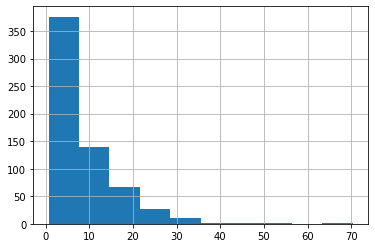

In [180]:
df_inner_split[df_inner_split['skn'] == 54]['data_in'].hist()

In [198]:
np.array(df_inner_split[df_inner_split['skn'] == 396]['data_in'])

array([7.830e+00, 3.800e+00, 2.280e+00, 1.750e+00, 2.300e-01, 1.000e-02,
       6.800e-01, 8.000e-02, 3.700e-01, 3.700e-01, 1.600e+00, 9.600e-01,
       5.340e+00, 3.340e+00, 3.700e-01, 2.500e-01, 2.000e-02, 2.400e-01,
       8.000e-02, 0.000e+00, 3.000e-02, 1.900e-01, 8.400e-01, 4.100e-01,
       7.640e+00, 6.100e-01, 1.220e+00, 5.680e+00, 2.500e-01, 0.000e+00,
       2.000e-01, 1.440e+00, 7.000e-02, 1.700e-01, 1.018e+01, 8.660e+00,
       2.270e+00, 6.410e+00, 8.350e+00, 9.000e-02, 0.000e+00, 9.000e-02,
       8.000e-02, 7.000e-02, 9.000e-02, 3.050e+00, 1.300e-01, 1.970e+00,
       5.570e+00, 5.000e-01, 6.300e-01, 1.200e-01, 3.000e-02, 2.000e-02,
       3.900e-01, 1.000e-01, 8.000e-02, 1.540e+00, 5.800e-01, 3.900e-01,
       7.400e-01, 1.900e+00, 1.770e+00, 4.700e-01, 5.500e-01, 0.000e+00,
       3.000e-02, 1.000e-02, 0.000e+00, 1.900e-01, 4.900e-01, 1.990e+00,
       5.400e-01, 9.200e-01, 3.090e+00, 1.550e+00, 5.600e-01, 3.000e-02,
       6.100e-01, 2.000e-01, 2.000e-02, 2.600e-01, 

In [197]:
np.log(np.array(df_inner_split[df_inner_split['skn'] == 396]['data_in']) + 5)

array([2.55178618, 2.17475172, 1.98513086, 1.9095425 , 1.65441128,
       1.61143592, 1.73695123, 1.62531126, 1.68082791, 1.68082791,
       1.88706965, 1.78507048, 2.33601987, 2.12106322, 1.68082791,
       1.65822808, 1.61342993, 1.6563215 , 1.62531126, 1.60943791,
       1.61541998, 1.6467337 , 1.7647308 , 1.68824909, 2.53686639,
       1.72455072, 1.82776991, 2.36837283, 1.65822808, 1.60943791,
       1.64865863, 1.86252854, 1.62334082, 1.64287269, 2.71997877,
       2.61447185, 1.98375629, 2.43449016, 2.59151638, 1.62727783,
       1.60943791, 1.62727783, 1.62531126, 1.62334082, 1.62727783,
       2.08567209, 1.63510566, 1.94161522, 2.3580198 , 1.70474809,
       1.72810944, 1.63315444, 1.61541998, 1.61342993, 1.68454538,
       1.62924054, 1.62531126, 1.87793717, 1.71918878, 1.68454538,
       1.74745921, 1.93152141, 1.91250109, 1.69927862, 1.71379793,
       1.60943791, 1.61541998, 1.61143592, 1.60943791, 1.6467337 ,
       1.70292826, 1.94448056, 1.7119945 , 1.77833645, 2.09062

In [186]:
a = np.array([1,2,3, 100])
np.log(a)

array([0.        , 0.69314718, 1.09861229, 4.60517019])